# Multi-point stress approximation (MPSA)

Porepy supports mpsa discretization for linear elasticity problem:
\begin{equation}
\nabla\cdot \sigma = -\vec f,\quad \vec x \in \Omega
\end{equation}
where $\vec f$ is a body force, and the stress $\sigma$ is given as a linear function of the displacement
\begin{equation}
\sigma = C:\vec u.
\end{equation}

The convention in porepy is that tension is positive. This means that the Cartesian component of the traction $\vec T = \sigma \cdot \vec n$, for a direction $\vec r$ is positive number if the inner product $\vec T\cdot \vec r$ is positive. The displacements will give the difference between the initial state of the rock and the deformed state. If we consider a point in its initial state $\vec x \in \Omega$ and let $\vec x^* \in \Omega$ be the same point in the deformed state, to be consistent with the convention we used for traction, the displacements are given by $\vec u = \vec x^* - \vec x$, that is, $u$ points from the initial state to the finial state.

To close the system we also need to define a set of boundary conditions. Here we have three posibilities, Neumman conditions, Dirichlet conditions or Robin conditions, and we divide the boundary into three disjont sets $\Gamma_N$, $\Gamma_D$ and $\Gamma_R$ for the three different types of boundary conditions
\begin{equation}
\vec u = g_D, \quad \vec x \in \Gamma_D\\
\sigma\cdot n = g_N, \quad \vec x \in \Gamma_N\\
\sigma\cdot n + W \vec u= g_R,\quad \vec x\in \Gamma_R
\end{equation}

To solve this system we first have to create the grid.

In [1]:
import numpy as np
import porepy as pp

# Create grid
n = 5
g = pp.CartGrid([n,n])
g.compute_geometry()


We also need to define the stress tensor $C$. In porepy the constutitive law,
\begin{equation}
\sigma = C:u = 2  \mu  \epsilon +\lambda  \text{trace}(\epsilon) I, \quad \epsilon = \frac{1}{2}(\nabla u + (\nabla u)^\top)
\end{equation}
is implemented, and to get the tensor for this law we call:

In [2]:
# Create stiffness matrix
lam = np.ones(g.num_cells)
mu = np.ones(g.num_cells)
C = pp.FourthOrderTensor(mu, lam)

Then we need to define boundary conditions. We set the bottom boundary as a Dirichlet boundary, and the other boundaries are set to Neuman.

In [3]:
# Define boundary type
dirich = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))
bound = pp.BoundaryConditionVectorial(g, dirich, ['dir']*dirich.size)

We discretize the stresses by using the multi-point stress approximation (for details, please see: E. Keilegavlen and J. M. Nordbotten. “Finite volume methods for elasticity with weak symmetry”. In: International Journal for Numerical Methods in Engineering (2017)).

We now define the values we put on the boundaries. We clamp the bottom boundary, and push down by a constant force on the top boundary. Note that the value of the Neumann condition given on a face $\pi$ is the integrated traction $\int_\pi g_N d\vec x$.

In [4]:
top_faces = np.ravel(np.argwhere(g.face_centers[1] > n - 1e-10))
bot_faces = np.ravel(np.argwhere(g.face_centers[1] < 1e-10))

u_b = np.zeros((g.dim, g.num_faces))
u_b[1, top_faces] = -1 * g.face_areas[top_faces]
u_b[:, bot_faces] = 0

u_b = u_b.ravel('F')

We discretize this system using the Mpsa class. We assume zero body forces $f=0$

In [5]:
mpsa_class = pp.Mpsa("mechanics")
f = np.zeros(g.dim * g.num_cells)

specified_parameters = {"fourth_order_tensor": C, "source": f, "bc": bound, "bc_values": u_b}
data = pp.initialize_default_data(g, {}, "mechanics", specified_parameters)
A, b = mpsa_class.assemble_matrix_rhs(g, data)

u_class = np.linalg.solve(A.A, b)

number of ncasym eliminated:  8
max igrad:  2.0


And we can plott the y_displacement

/home/rbe051/anaconda3/envs/porepy/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:738: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


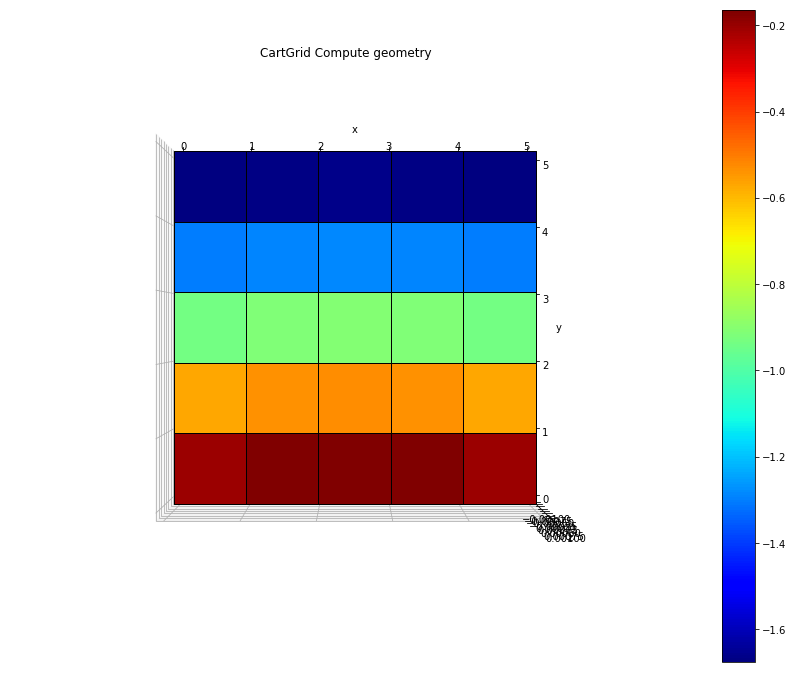

In [6]:
pp.plot_grid(g, cell_value=u_class[1::2], figsize=(15, 12))

To better understand what goes on under the hood of the mpsa class, we manually create the lhs and rhs

In [7]:
constit = pp.FourthOrderTensor(mu, lam)
stress, bound_stress, *_ = pp.numerics.fv.mpsa.mpsa(g, constit, bound)

number of ncasym eliminated:  8
max igrad:  2.0


MPSA returns the two sparse matrices "stress" and "bound_stress". They give define the discretization of the cell-face traction:
\begin{equation}
T = \text{stress} \cdot u + \text{bound_stress} \cdot u_b
\end{equation}
Here $u$ is a vector of cell center displacement and has length g.dim $*$ g.num_cells. The vector $u_b$ is the boundary condition values. It is the displacement for Dirichlet boundaries and traction for Neumann boundaries and has length g.dim $*$ g.num_faces.


We are now ready to set up the linear system of equations and solve it. We define the body forces $f = 0$. Each row in the discretized system is now
\begin{equation}
-\int_{\Omega_k} f dv = \int_{\partial\Omega_k} T(n)dA = [div \cdot \text{stress} \cdot u + div\cdot\text{bound_stress}\cdot u_b]_k,
\end{equation}
We move the known boundary variable $u_b$ over to the right hand side and solve the system:


In [8]:
f = np.zeros(g.dim * g.num_cells)

div = pp.fvutils.vector_divergence(g)
A = div * stress
b = -f - div * bound_stress * u_b

u = np.linalg.solve(A.A, b)

This gives the same displacement as for the Mpsa class:

In [9]:
assert np.allclose(u, u_class)

We can also retrieve the traction on the faces. 

/home/rbe051/anaconda3/envs/porepy/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:738: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


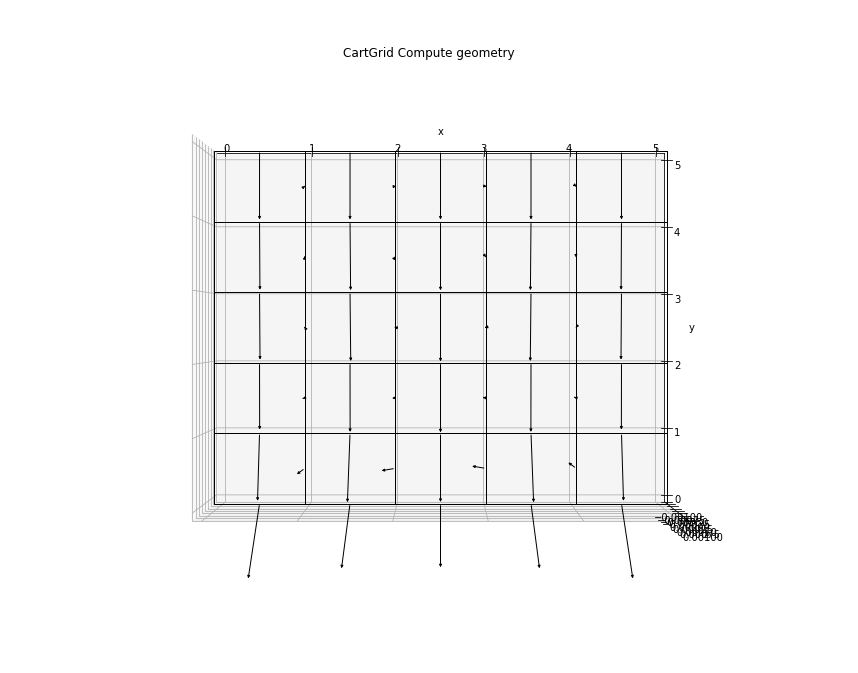

In [10]:
T = stress * u + bound_stress * u_b

T2d = np.reshape(T, (g.dim, -1), order='F')
u_b2d = np.reshape(u_b, (g.dim, -1), order='F')
assert np.allclose(np.abs(u_b2d[bound.is_neu]), np.abs(T2d[bound.is_neu]))

T = np.vstack((T2d, np.zeros(g.num_faces)))
pp.plot_grid(g, vector_value=T, figsize=(15, 12), alpha=0)

Note that the traction on face i: T[2*i:2*i+g.dim] is the traction on the face as defined by the normal vectors g.face_normals. This means that for the bottom boundary, the traction T[bot] is the force from to box on the outside (since the normal vectors here are [0,1]), while on the top boundary, the traction T[top] is the force applied to to top faces from the outside (since the normals here point out of the domain).